### Atsu Atakpa
### Natural Language Processing - Assignment 8

Cluster the reviews that you collected in homework 5, by doing the following:

    1.	In Python, select any one of the clustering methods covered in this course. Run it over the collection of reviews, and show at least two different ways of clustering the reviews, e.g., changing k in k-Means clustering or changing where you “cut” in Agnes or Diana.

    2.	Try to write a short phrase to characterize (give a natural interpretation of) what each cluster is generally centered on semantically. Is this hard to do in some cases? If so, make note of that fact.

    3.	Explain which of the two clustering results from question 1 is preferable (if one of them is), and why.

Submit all of your inputs and outputs and your code for this assignment, along with a brief written explanation of your findings. 


In [1]:
import warnings
warnings.filterwarnings('ignore')
from __future__ import division, print_function
from nltk import word_tokenize
#from urllib.request import urlopen
from urllib2 import Request, urlopen 
from bs4 import BeautifulSoup, SoupStrainer
import nltk; print("NLTK",nltk.__version__)
import bs4; print("Beautiful Soup",bs4.__version__)
import re; print("RE",re.__version__)
import requests; print("Requests",requests.__version__)
import numpy as np ; print("Numpy: ", np.__version__)
import sys ;print("System version: ", sys.version)
from pattern.en import tag , parsetree, parse
import sklearn; print( 'sklearn ' + sklearn.__version__)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn as sn; print( 'seaborn ' + sn.__version__)
import matplotlib as plt; print( 'matplotlib' + plt.__version__)


NLTK 3.3
Beautiful Soup 4.6.0
RE 2.2.1
Requests 2.18.4
Numpy:  1.14.3
System version:  2.7.15 |Anaconda, Inc.| (default, May  1 2018, 18:37:09) [MSC v.1500 64 bit (AMD64)]
sklearn 0.19.1
seaborn 0.8.1
matplotlib2.2.2


### Importing review URLs from csv file

In [2]:
import pandas as pd
from bs4 import BeautifulSoup
#import requests
import pprint
#import re

final_df = pd.DataFrame(columns=['title','review'])
dataframe = pd.read_csv('C:/Users/atsua/OneDrive/Documents/SMU/7. Natural Language Processing/Final Project/movie_review_final.csv',header=None)

for idx, row in dataframe.iterrows():
   url = row[0]
   response = requests.get(url)
   soup = BeautifulSoup(response.content, "html.parser")

   #print titles only
   title = soup.find("h1", class_= "header")
   #ab = print(h1.get_text())
   review = soup.find("div", class_= "text show-more__control")
   title_clean = (title.get_text().replace('Review of ',''))
   review_clean = review.get_text()
   tmp_df = pd.DataFrame({'title': [title_clean], 'review' : [review_clean]})
   final_df = final_df.append(tmp_df, ignore_index=True)

In [3]:
final_df.count()

review    100
title     100
dtype: int64

In [4]:
final_df = final_df[['title', 'review']]

In [5]:
final_df.head()

,title,review
0,The Shawshank Redemption,Why do I want to write the 234th comment on Th...
1,The Godfather,Tell me a movie that is more famous than this....
2,The Godfather: Part II,This movie is way to be good to be labelled a ...
3,The Dark Knight,We've been subjected to enormous amounts of hy...
4,12 Angry Men,'12 Angry Men' is an outstanding film. It is p...


In [6]:
#final_df.to_csv('movie_reviews_dataframe.csv', encoding ='utf-8')

In [7]:
# Review of the 6th item in the our datafame
final_df.review[5]

u"Schindler's List is undoubtedly the best Holocaust film ever made. There just isn't anything like this film. Various other films have tried to show the true horrors of the Holocaust, but none of them succeeded the way that Schindler's List did. Schindler's List is a difficult film to watch. When you see the true atrocities of the Holocaust, your jaw drops. When you see the pain that all of the innocent people were going through, the only thing you can do is cry. The true goal of all Holocaust films is to make you feel sorrowful, and Schindler's List did that to me. If you want to see the best depiction of the Holocaust, make your way towards Schindler's List."

In [8]:
from normalization import normalize_corpus
from utils import build_feature_matrix

# normalize corpus
norm_movie_synopses = normalize_corpus(final_df.review,
                                       lemmatize=True,
                                       only_text_chars=True)

# extract tf-idf features
vectorizer, feature_matrix = build_feature_matrix(norm_movie_synopses,
                                                  feature_type='tfidf',
                                                  min_df=0.24, max_df=0.85,
                                                  ngram_range=(1, 2))
# view number of features
print (feature_matrix.shape)    

(100, 37)


  #### The shape of our feature matrix is 106 movie reviews and 37 features each

In [9]:
# get feature names
feature_names = vectorizer.get_feature_names()
# print sample features
print (feature_names[:41])  

[u'actor', u'best', u'character', u'could', u'director', u'end', u'even', u'ever', u'film', u'first', u'give', u'good', u'great', u'know', u'like', u'many', u'movie', u'much', u'people', u'play', u'plot', u'really', u'scene', u'seem', u'story', u'take', u'thing', u'think', u'time', u'want', u'watch', u'way', u'well', u'without', u'work', u'would', u'year']


##### These 37 features are TF-IDF based features for unigram and bigrams. Each feature occurs in at least 25% to a maximum of 85% of documents.

### K-Means Clustering (K=5)

In [10]:
from sklearn.cluster import KMeans

def k_means(feature_matrix, num_clusters=5):
    km = KMeans(n_clusters=num_clusters,
                max_iter=10000)
    km.fit(feature_matrix)
    clusters = km.labels_
    return km, clusters

num_clusters = 5    
km_obj, clusters = k_means(feature_matrix=feature_matrix,
                           num_clusters=num_clusters)
final_df['Cluster'] = clusters

In [11]:
from collections import Counter
# get the total number of movies per cluster
c = Counter(clusters)
print (c.items())

[(0, 26), (1, 8), (2, 28), (3, 11), (4, 27)]


In [12]:
def get_cluster_data(clustering_obj, final_df, 
                     feature_names, num_clusters,
                     topn_features=10):

    cluster_details = {}  
    # get cluster centroids
    ordered_centroids = clustering_obj.cluster_centers_.argsort()[:, ::-1]
    # get key features for each cluster
    # get movies belonging to each cluster
    for cluster_num in range(num_clusters):
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster_num'] = cluster_num
        key_features = [feature_names[index] 
                        for index 
                        in ordered_centroids[cluster_num, :topn_features]]
        cluster_details[cluster_num]['key_features'] = key_features
        
        movies = final_df[final_df['Cluster'] == cluster_num]['title'].values.tolist()
        cluster_details[cluster_num]['movies'] = movies
    
    return cluster_details

In [13]:
def print_cluster_data(cluster_data):
    # print cluster details
    for cluster_num, cluster_details in cluster_data.items():
        print ('Cluster {} details:'.format(cluster_num))
        print('-'*20)
        print ('Key features:', cluster_details['key_features'])
        print ('Movies in this cluster:')
        print (', '.join(cluster_details['movies']))
        print ('='*40)

In [14]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
import random
from matplotlib.font_manager import FontProperties

def plot_clusters(num_clusters, feature_matrix,
                  cluster_data, movie_data,
                  plot_size=(16,8)):
    # generate random color for clusters                  
    def generate_random_color():
        color = '#%06x' % random.randint(0, 0xFFFFFF)
        return color
    # define markers for clusters    
    markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd']
    # build cosine distance matrix
    cosine_distance = 1 - cosine_similarity(feature_matrix) 
    # dimensionality reduction using MDS
    mds = MDS(n_components=2, dissimilarity="precomputed", 
              random_state=1)
    # get coordinates of clusters in new low-dimensional space
    plot_positions = mds.fit_transform(cosine_distance)  
    x_pos, y_pos = plot_positions[:, 0], plot_positions[:, 1]
    # build cluster plotting data
    cluster_color_map = {}
    cluster_name_map = {}
    for cluster_num, cluster_details in cluster_data.items():
        # assign cluster features to unique label
        cluster_color_map[cluster_num] = generate_random_color()
        cluster_name_map[cluster_num] = ', '.join(cluster_details['key_features'][:5]).strip()
    # map each unique cluster label with its coordinates and movies
    cluster_plot_frame = pd.DataFrame({'x': x_pos,
                                       'y': y_pos,
                                       'label': final_df['Cluster'].values.tolist(),
                                       'title': final_df['title'].values.tolist()
                                        })
    grouped_plot_frame = cluster_plot_frame.groupby('label')
    # set plot figure size and axes
    fig, ax = plt.subplots(figsize=plot_size) 
    ax.margins(0.05)
    # plot each cluster using co-ordinates and movie titles
    for cluster_num, cluster_frame in grouped_plot_frame:
         marker = markers[cluster_num] if cluster_num < len(markers) \
                  else np.random.choice(markers, size=1)[0]
         ax.plot(cluster_frame['x'], cluster_frame['y'], 
                 marker=marker, linestyle='', ms=12,
                 label=cluster_name_map[cluster_num], 
                 color=cluster_color_map[cluster_num], mec='none')
         ax.set_aspect('auto')
         ax.tick_params(axis= 'x', which='both', bottom='off', top='off',        
                        labelbottom='off')
         ax.tick_params(axis= 'y', which='both', left='off', top='off',         
                        labelleft='off')
    fontP = FontProperties()
    fontP.set_size('small')    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=True, 
              shadow=True, ncol=5, numpoints=1, prop=fontP) 
    #add labels as the film titles
    for index in range(len(cluster_plot_frame)):
        ax.text(cluster_plot_frame.ix[index]['x'], 
                cluster_plot_frame.ix[index]['y'], 
                cluster_plot_frame.ix[index]['title'], size=8)  
    # show the plot           
    plt.show() 

In [15]:
cluster_data =  get_cluster_data(clustering_obj=km_obj,
                                 final_df=final_df,
                                 feature_names=feature_names,
                                 num_clusters=num_clusters,
                                 topn_features=10)         

print_cluster_data(cluster_data) 

Cluster 0 details:
--------------------
Key features: [u'film', u'story', u'movie', u'scene', u'good', u'character', u'seem', u'like', u'great', u'work']
Movies in this cluster:
The Dark Knight, The Lord of the Rings: The Return of the King, Pulp Fiction, The Good, the Bad and the Ugly, The Lord of the Rings: The Fellowship of the Ring, Forrest Gump, The Matrix, City of God, Se7en, The Silence of the Lambs, The Usual Suspects, Spirited Away, City Lights, Modern Times, Gladiator, Alien, Cinema Paradiso, Django Unchained, Princess Mononoke, Coco, M, Dangal, A Clockwork Orange, Double Indemnity, Singin' in the Rain, Toy Story 3
Cluster 1 details:
--------------------
Key features: [u'plot', u'movie', u'much', u'want', u'watch', u'end', u'people', u'many', u'good', u'seem']
Movies in this cluster:
Léon: The Professional, The Pianist, Terminator 2: Judgment Day, The Prestige, Avengers: Infinity War, The Lives of Others, Paths of Glory, Your Name.
Cluster 2 details:
--------------------
Key 

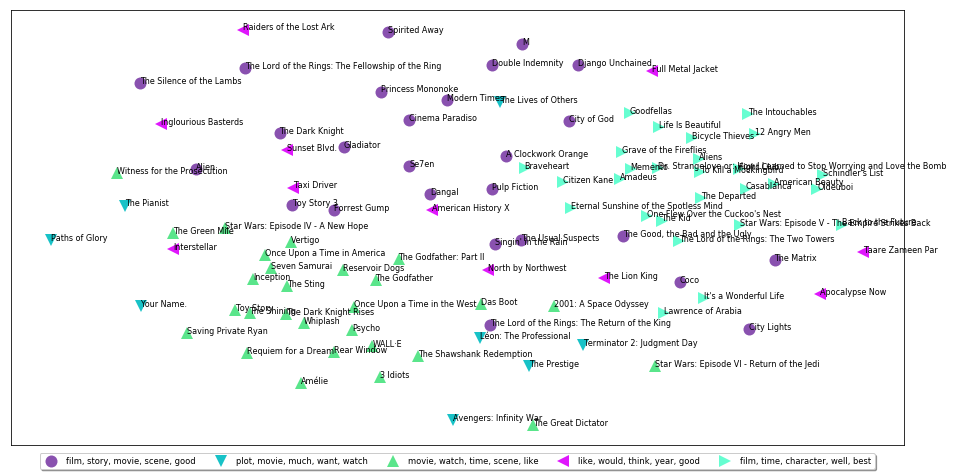

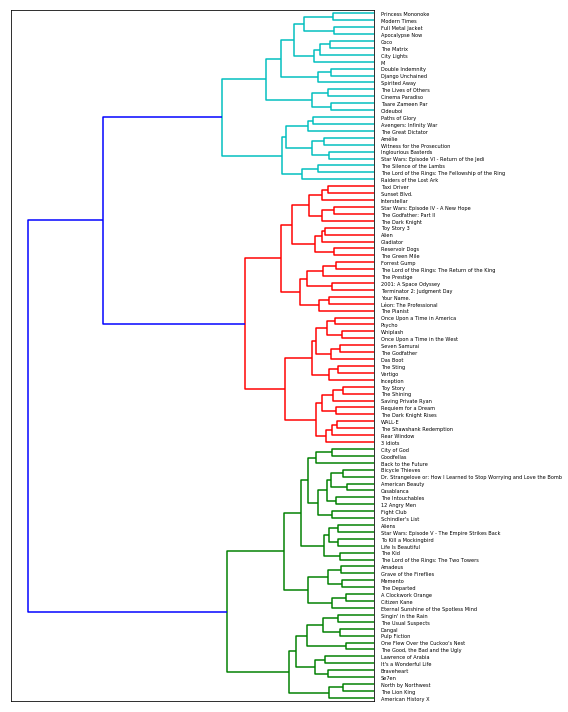

In [16]:
#print_cluster_data(cluster_data) 
import warnings
warnings.filterwarnings('ignore')

plot_clusters(num_clusters=num_clusters, 
              feature_matrix=feature_matrix,
              cluster_data=cluster_data, 
              movie_data=final_df,
              plot_size=(16,8)) 





from scipy.cluster.hierarchy import ward, dendrogram

def ward_hierarchical_clustering(feature_matrix):
    
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix
    
def plot_hierarchical_clusters(linkage_matrix, movie_data, figure_size=(8,12)):
    # set size
    fig, ax = plt.subplots(figsize=figure_size) 
    movie_titles = movie_data['title'].values.tolist()
    # plot dendrogram
    ax = dendrogram(linkage_matrix, orientation="left", labels=movie_titles)
    plt.tick_params(axis= 'x',   
                    which='both',  
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()
    plt.savefig('ward_hierachical_clusters.png', dpi=200)

# build ward's linkage matrix    
linkage_matrix = ward_hierarchical_clustering(feature_matrix)
# plot the dendrogram
plot_hierarchical_clusters(linkage_matrix=linkage_matrix,
                           movie_data=final_df,
                           figure_size=(8,10))

### K-Means Clustering (K = 4)

In [17]:
from sklearn.cluster import KMeans

def k_means(feature_matrix, num_clusters=2):
    km = KMeans(n_clusters=num_clusters,
                max_iter=10000)
    km.fit(feature_matrix)
    clusters = km.labels_
    return km, clusters

num_clusters = 4    
km_obj, clusters = k_means(feature_matrix=feature_matrix,
                           num_clusters=num_clusters)
final_df['Cluster'] = clusters

In [18]:
final_df.Cluster.head()

0    1
1    1
2    2
3    2
4    3
Name: Cluster, dtype: int32

In [19]:
final_df.Cluster.describe()

count    100.000000
mean       1.700000
std        1.167748
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        3.000000
Name: Cluster, dtype: float64

### Scree plot to select the appropriate k-value

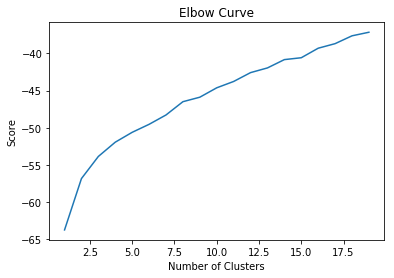

In [20]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(feature_matrix).score(feature_matrix) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [21]:
from collections import Counter
# get the total number of movies per cluster
c = Counter(clusters)
print (c.items())

[(0, 20), (1, 27), (2, 16), (3, 37)]


In [22]:
def get_cluster_data(clustering_obj, final_df, 
                     feature_names, num_clusters,
                     topn_features=10):

    cluster_details = {}  
    # get cluster centroids
    ordered_centroids = clustering_obj.cluster_centers_.argsort()[:, ::-1]
    # get key features for each cluster
    # get movies belonging to each cluster
    for cluster_num in range(num_clusters):
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster_num'] = cluster_num
        key_features = [feature_names[index] 
                        for index 
                        in ordered_centroids[cluster_num, :topn_features]]
        cluster_details[cluster_num]['key_features'] = key_features
        
        movies = final_df[final_df['Cluster'] == cluster_num]['title'].values.tolist()
        cluster_details[cluster_num]['movies'] = movies
    
    return cluster_details

In [23]:
def print_cluster_data(cluster_data):
    # print cluster details
    for cluster_num, cluster_details in cluster_data.items():
        print ('Cluster {} details:'.format(cluster_num))
        print('-'*20)
        print ('Key features:', cluster_details['key_features'])
        print ('Movies in this cluster:')
        print (', '.join(cluster_details['movies']))
        print ('='*40)

In [24]:
def plot_clusters(num_clusters, feature_matrix,
                  cluster_data, movie_data,
                  plot_size=(16,8)):
    # generate random color for clusters                  
    def generate_random_color():
        color = '#%06x' % random.randint(0, 0xFFFFFF)
        return color
    # define markers for clusters    
    markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd']
    # build cosine distance matrix
    cosine_distance = 1 - cosine_similarity(feature_matrix) 
    # dimensionality reduction using MDS
    mds = MDS(n_components=2, dissimilarity="precomputed", 
              random_state=1)
    # get coordinates of clusters in new low-dimensional space
    plot_positions = mds.fit_transform(cosine_distance)  
    x_pos, y_pos = plot_positions[:, 0], plot_positions[:, 1]
    # build cluster plotting data
    cluster_color_map = {}
    cluster_name_map = {}
    for cluster_num, cluster_details in cluster_data.items():
        # assign cluster features to unique label
        cluster_color_map[cluster_num] = generate_random_color()
        cluster_name_map[cluster_num] = ', '.join(cluster_details['key_features'][:5]).strip()
    # map each unique cluster label with its coordinates and movies
    cluster_plot_frame = pd.DataFrame({'x': x_pos,
                                       'y': y_pos,
                                       'label': final_df['Cluster'].values.tolist(),
                                       'title': final_df['title'].values.tolist()
                                        })
    grouped_plot_frame = cluster_plot_frame.groupby('label')
    # set plot figure size and axes
    fig, ax = plt.subplots(figsize=plot_size) 
    ax.margins(0.05)
    # plot each cluster using co-ordinates and movie titles
    for cluster_num, cluster_frame in grouped_plot_frame:
         marker = markers[cluster_num] if cluster_num < len(markers) \
                  else np.random.choice(markers, size=1)[0]
         ax.plot(cluster_frame['x'], cluster_frame['y'], 
                 marker=marker, linestyle='', ms=12,
                 label=cluster_name_map[cluster_num], 
                 color=cluster_color_map[cluster_num], mec='none')
         ax.set_aspect('auto')
         ax.tick_params(axis= 'x', which='both', bottom='off', top='off',        
                        labelbottom='off')
         ax.tick_params(axis= 'y', which='both', left='off', top='off',         
                        labelleft='off')
    fontP = FontProperties()
    fontP.set_size('small')    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=True, 
              shadow=True, ncol=5, numpoints=1, prop=fontP) 
    #add labels as the film titles
    for index in range(len(cluster_plot_frame)):
        ax.text(cluster_plot_frame.ix[index]['x'], 
                cluster_plot_frame.ix[index]['y'], 
                cluster_plot_frame.ix[index]['title'], size=8)  
    # show the plot           
    plt.show() 

In [25]:
cluster_data =  get_cluster_data(clustering_obj=km_obj,
                                 final_df=final_df,
                                 feature_names=feature_names,
                                 num_clusters=num_clusters,
                                 topn_features=10)         

print_cluster_data(cluster_data) 

Cluster 0 details:
--------------------
Key features: [u'scene', u'film', u'like', u'would', u'way', u'story', u'first', u'great', u'think', u'give']
Movies in this cluster:
The Lord of the Rings: The Fellowship of the Ring, The Matrix, The Silence of the Lambs, Spirited Away, American History X, City Lights, Modern Times, Raiders of the Lost Ark, The Lion King, Apocalypse Now, Alien, Sunset Blvd., Django Unchained, Princess Mononoke, Coco, North by Northwest, Star Wars: Episode VI - Return of the Jedi, M, Inglourious Basterds, Full Metal Jacket
Cluster 1 details:
--------------------
Key features: [u'movie', u'watch', u'plot', u'like', u'end', u'scene', u'want', u'good', u'many', u'much']
Movies in this cluster:
The Shawshank Redemption, The Godfather, The Lord of the Rings: The Return of the King, Seven Samurai, Saving Private Ryan, Léon: The Professional, Interstellar, Psycho, The Pianist, Terminator 2: Judgment Day, Whiplash, Rear Window, The Prestige, Avengers: Infinity War, The G

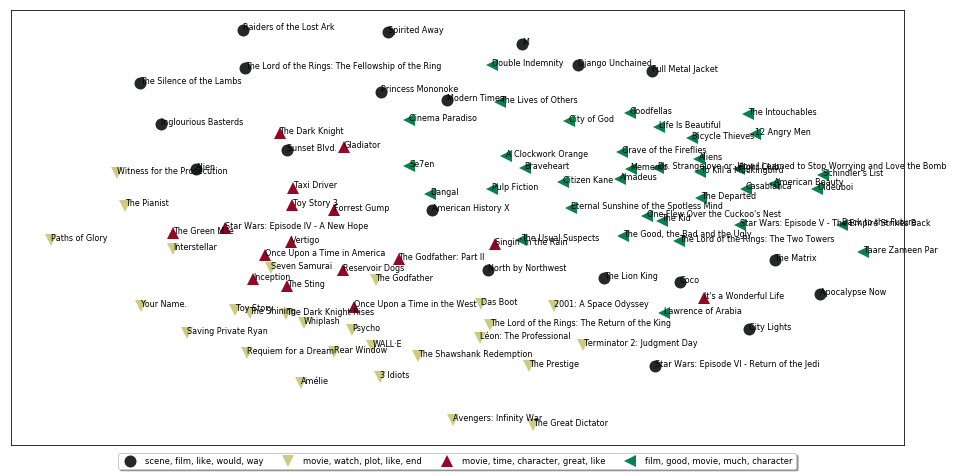

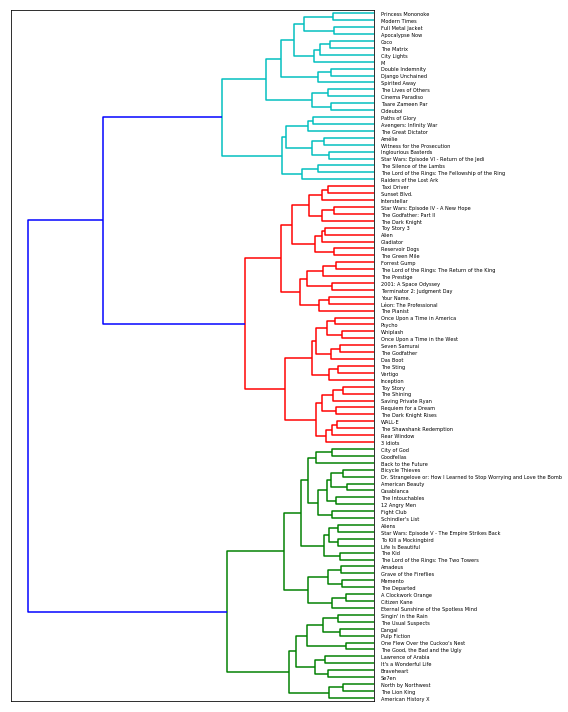

In [26]:
#print_cluster_data(cluster_data) 
import warnings
warnings.filterwarnings('ignore')

plot_clusters(num_clusters=num_clusters, 
              feature_matrix=feature_matrix,
              cluster_data=cluster_data, 
              movie_data=final_df,
              plot_size=(16,8)) 





from scipy.cluster.hierarchy import ward, dendrogram

def ward_hierarchical_clustering(feature_matrix):
    
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix
    
def plot_hierarchical_clusters(linkage_matrix, movie_data, figure_size=(8,12)):
    # set size
    fig, ax = plt.subplots(figsize=figure_size) 
    movie_titles = movie_data['title'].values.tolist()
    # plot dendrogram
    ax = dendrogram(linkage_matrix, orientation="left", labels=movie_titles)
    plt.tick_params(axis= 'x',   
                    which='both',  
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()
    plt.savefig('ward_hierachical_clusters.png', dpi=200)

# build ward's linkage matrix    
linkage_matrix = ward_hierarchical_clustering(feature_matrix)
# plot the dendrogram
plot_hierarchical_clusters(linkage_matrix=linkage_matrix,
                           movie_data=final_df,
                           figure_size=(8,10))

# Question 1

In [27]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\atsua\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [28]:
analyzer = SentimentIntensityAnalyzer()

In [29]:
def sentiment_analyzer_scores(sentence):
    score = analyzer.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

In [30]:
sentiment_analyzer_scores(final_df.review[5])

Schindler's List is undoubtedly the best Holocaust film ever made. There just isn't anything like this film. Various other films have tried to show the true horrors of the Holocaust, but none of them succeeded the way that Schindler's List did. Schindler's List is a difficult film to watch. When you see the true atrocities of the Holocaust, your jaw drops. When you see the pain that all of the innocent people were going through, the only thing you can do is cry. The true goal of all Holocaust films is to make you feel sorrowful, and Schindler's List did that to me. If you want to see the best depiction of the Holocaust, make your way towards Schindler's List. {'neg': 0.153, 'neu': 0.699, 'pos': 0.148, 'compound': -0.203}


In [31]:
sentiment_analyzer_scores(final_df.review[30])

If you saw "sunshine" and thought "wow, good thing they had scientist advisers, this stuff is so plausible", you will like "interstellar".If you saw "armaggeddon" and thought "what an awesome movie, i just wished they would have dragged the scene where he says goodbye to his daughter out even more", you will like "interstellar".If you saw "inception" and thought "this movie would be so much better in SPACE!", you will like "interstellar".And if you liked "2001" or any other intelligent/geeky sci-fi movie, you will hate "interstellar".Like some of Nolan's earlier works, it's long for the sake of length only. Its plot is up there with "armaggeddon" in pure stupidity and forced US-cowboy-patriot-macho-ism, its special effects are underwhelming, its plot twists are obvious, its setting makes no sense, its characters are flat and forgettable, and its constant citations of "2001" just serve to make you remember how much better Kubrick did all of this with a tiny fraction of the money almost 

In [32]:
import nltk # be sure to have stopwords installed for this using nltk.download_shell()
import pandas as pd 
import string
#messages = [line.rstrip() for line in open("filepath goes here")]
messages = final_df.review
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# install Vader and make sure you download the lexicon as well
sid = SentimentIntensityAnalyzer()
# this step will return an error if you have not installed the lexicon
summary = {"positive":0,"neutral":0,"negative":0}
for x in messages: 
    ss = sid.polarity_scores(x)
    if ss["compound"] == 0.0: 
        summary["neutral"] +=1
    elif ss["compound"] > 0.0:
        summary["positive"] +=1
    else:
        summary["negative"] +=1
print(summary)

{'positive': 62, 'neutral': 0, 'negative': 38}


In [33]:
a = pd.DataFrame.from_dict(summary,orient='index')

In [34]:
a

,0
positive,62
neutral,0
negative,38


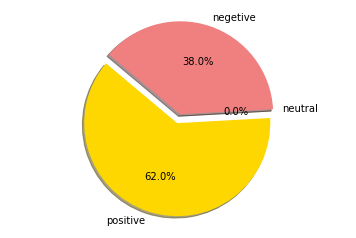

In [35]:
import matplotlib.pyplot as plt
 
# Data to plot
labels = 'positive', 'neutral', 'negetive'
sizes = [62, 0, 38]
colors = ['gold', 'yellowgreen', 'lightcoral']#, 'lightskyblue']
explode = (0.1, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

In [36]:
final_df.head()

,title,review,Cluster
0,The Shawshank Redemption,Why do I want to write the 234th comment on Th...,1
1,The Godfather,Tell me a movie that is more famous than this....,1
2,The Godfather: Part II,This movie is way to be good to be labelled a ...,2
3,The Dark Knight,We've been subjected to enormous amounts of hy...,2
4,12 Angry Men,'12 Angry Men' is an outstanding film. It is p...,3


In [37]:
#final_df.Cluster.describe()

In [38]:
#pd.crosstab(final_df.Cluster,  margins=True)

In [39]:
final_df.Cluster.value_counts()

3    37
1    27
0    20
2    16
Name: Cluster, dtype: int64

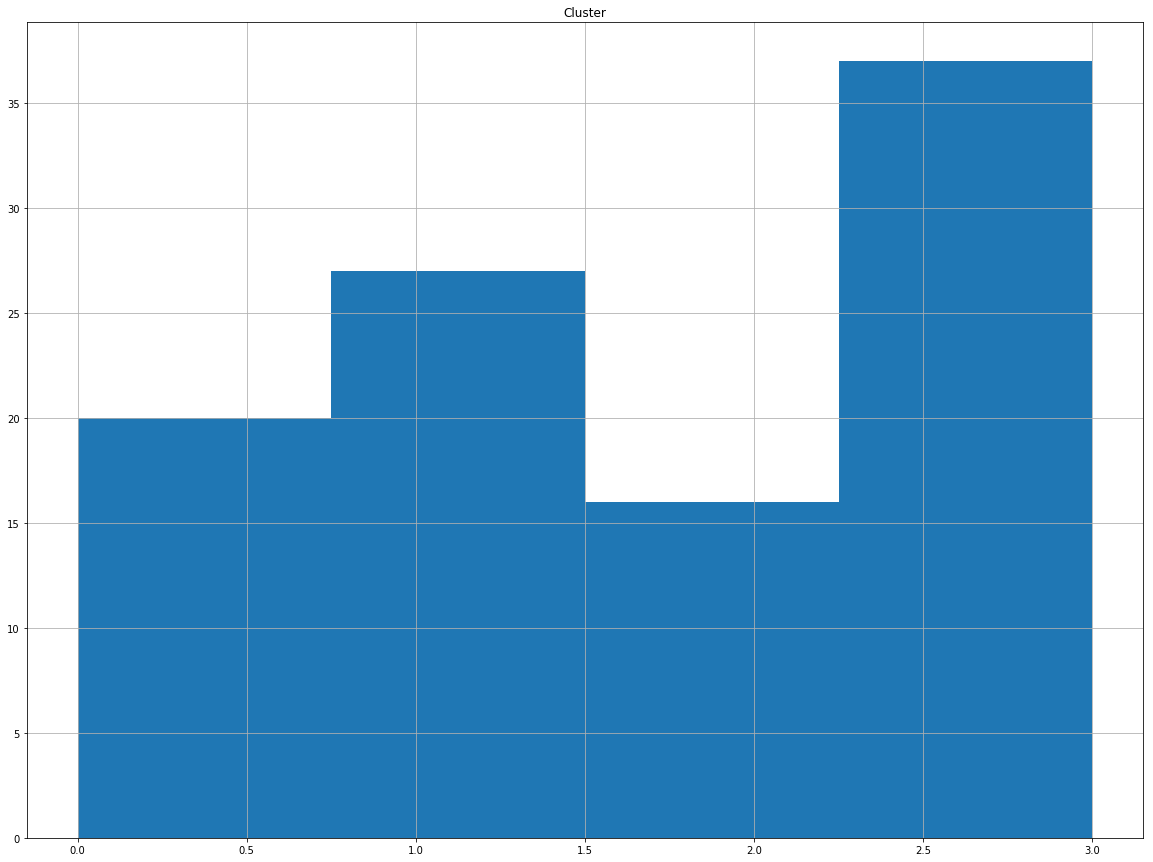

In [40]:
#Histogram of variales
num_bins = 4
final_df.hist(bins=num_bins, figsize=(20,15))
plt.savefig("incidents_histogram_plots")
plt.show()

# Question 2

In [41]:
from textblob import TextBlob

# compute sentiment scores (polarity) and labels
sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in final_df['review']]
sentiment_category_tb = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores_tb]


# sentiment statistics per news category
df = pd.DataFrame([list(final_df['Cluster']), sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['Cluster_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['Cluster_category']).describe()

sentiment_score                                            \
                           count      mean       std    min    25%     50%   
Cluster_category                                                             
0                           20.0  0.090800  0.150758 -0.397  0.055  0.0905   
1                           27.0  0.114370  0.151559 -0.165  0.023  0.0990   
2                           16.0  0.134750  0.116070 -0.128  0.053  0.1310   
3                           37.0  0.120865  0.114122 -0.098  0.045  0.0960   

                                  
                      75%    max  
Cluster_category                  
0                 0.18475  0.301  
1                 0.21950  0.405  
2                 0.19975  0.387  
3                 0.18900  0.392

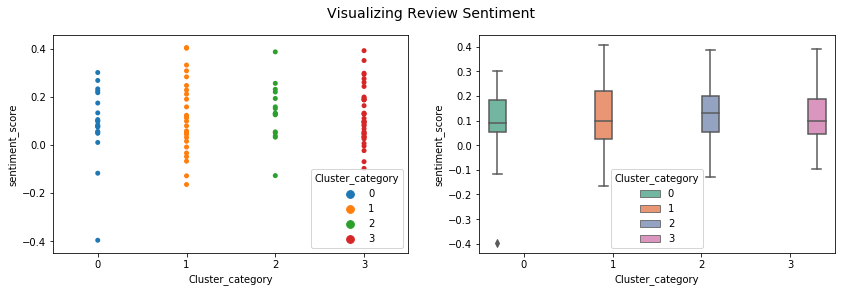

In [42]:
import seaborn as sns
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='Cluster_category', y="sentiment_score", 
                   hue='Cluster_category', data=df, ax=ax1)
bp = sns.boxplot(x='Cluster_category', y="sentiment_score", 
                 hue='Cluster_category', data=df, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing Review Sentiment', fontsize=14)

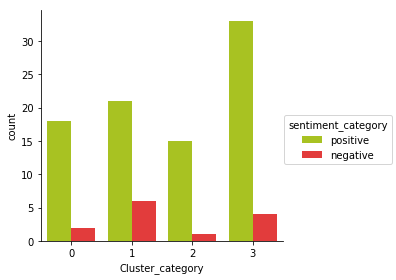

In [43]:
fc = sns.factorplot(x="Cluster_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

Each cluster has an interesting distribution of both positive and negetive reviews. The distribution of positive reviews is much greater than expected.